In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning
from pytorch_lightning import Trainer
from dataloader import Dataset
import os
import vae
from model import Model
import simplejson 
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage as pil
from torchvision.utils import make_grid
from PIL import Image
from IPython.display import display
import statistics
from torchvision.datasets import CelebA, MNIST
from torchvision.transforms.functional import convert_image_dtype
from torchvision import transforms
from collections import OrderedDict

torch.manual_seed(1)

# Setup
## Dataset

In [2]:
class fakeMNIST(MNIST):
    def __init__(self, data, transform=None) -> None:
        self.data = data
        self.transform = transform
        self.target_transform = None
        self.targets = torch.zeros(self.data.shape[0])
    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index].unsqueeze(0), int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self) -> int:
        return len(self.data)

In [3]:
dir = '/home/sonia/generative-models/data'
trans = transforms.Compose([transforms.Resize(64),])
dataset = MNIST(dir, train=True, download=True)
images = dataset.data
labels = dataset.targets
pu = 0.05 #probability of unusual color

def torch_bernoilli(p, size):
    return (torch.rand(size) < p).float()
flip = torch_bernoilli(pu, len(labels)) # 1 means the example will be the unusual color

images = trans(images)
images = torch.stack([images, images, images], dim=1) #makes 3-channel images in a new dimension 1
# dimension 0 is number of images, 1 is channels, 2 and 3 are image dimensions
images[torch.tensor(range(len(images))), (1-flip).long(), :, :] *= 0
# self.images = images.byte().float()
images = convert_image_dtype(images)
images.shape

torch.Size([60000, 3, 64, 64])

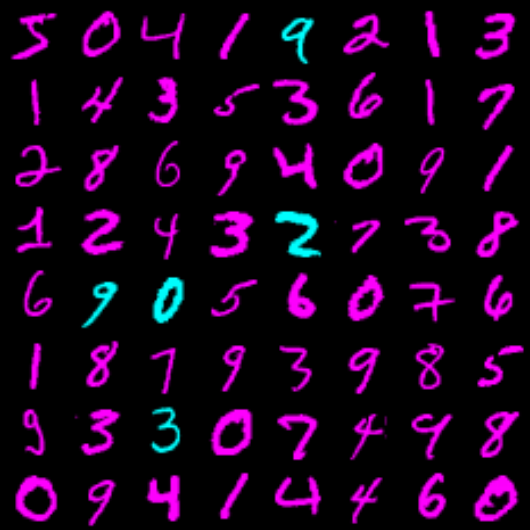

In [4]:
pil()(make_grid(images[:64], nrow=8))

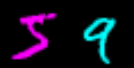

In [5]:
p = images[0]
b = images[4]
pil()(make_grid([p,b]))

### Determine if an image is blue or pink
0 is blue, 1 pink, -1 toss up

In [6]:
def findcolor(imgs, tolerance=0.2):
    imgs = (imgs[:, 0:2, :, :].flatten(start_dim=2, end_dim=3) > 0.07) #drop 3rd channel, find 'active' pixels
    proportion_pink = imgs[:, 0, :].sum(axis=1) / (imgs[:, 0, :].sum(axis=1) + imgs[:, 1, :].sum(axis=1))
    # print(proportion_pink[:100])
    proportion_pink[proportion_pink< tolerance] = 0 #blues
    proportion_pink[proportion_pink>=1-tolerance] = 1 #pinks
    proportion_pink[(proportion_pink< 1-tolerance) & (proportion_pink>=tolerance)] = -1 #tossup
    return proportion_pink

In [7]:
findcolor(p.unsqueeze(0))

tensor([1.])

In [8]:
prop = findcolor(images)

In [9]:
np.unique(prop[:100], return_counts=True)

(array([0., 1.], dtype=float32), array([ 6, 94]))

## MNIST classifier

In [2]:
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - n_class (Output)
    """
    def __init__(self, n_channel=1, n_class=10):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(n_channel, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, n_class)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_nums = LeNet5().eval()
sd = torch.hub.load_state_dict_from_url(
    'https://github.com/csinva/gan-vae-pretrained-pytorch/blob/master/mnist_classifier/weights/lenet_epoch=12_test_acc=0.991.pth?raw=true')
class_nums.load_state_dict(sd)
net = class_nums.to(device)

In [12]:
trans = transforms.Compose([transforms.Resize((32,32)),
                                        # transforms.ToTensor() 
                                        ])
data = fakeMNIST(images[:, 2, :, :], trans)

In [13]:
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=60000,
                                          shuffle=False)
ims = next(iter(data_loader)) # get whole dataset
ims = ims[0].to(device) # ims[1] is just filler 'labels'
preds = net(ims).cpu().detach().numpy()
class_preds = np.argmax(preds, axis=1)
class_preds

array([5, 0, 4, ..., 5, 6, 8])

In [14]:
np.sum(class_preds == labels.numpy()) / len(labels)

0.99625

In [15]:
# for visualization
def normalize(v):
    v = v-v.min()
    v = v/v.max()
    return v

## Color classifier

In [3]:
from dataloader import coloredMNISTbi
train_color_data = coloredMNISTbi(
        './data',
        split = 'train',
        transform = transforms.Resize(32),
        deterministic = False,
        labels='colors'
    )
train_color_loader = torch.utils.data.DataLoader(train_color_data, 
                                            batch_size=64,
                                            shuffle=False)
class_cols = LeNet5(n_channel=3, n_class=2).cuda()
optimizer = torch.optim.Adam(params=class_cols.parameters(), lr=0.01)

In [4]:
for epoch in range(10):
    for img, lab in train_color_loader: 
        optimizer.zero_grad()
        # print(img.shape, lab.shape)
        pred = class_cols(img.cuda()) #.argmax(axis=1)
        # print(pred)
        # print(lab)
        # loss = torch.sum(pred==lab.cuda())
        loss = nn.CrossEntropyLoss()(pred, lab.cuda().long())
        print(loss.item())
        loss.backward()
        optimizer.step()


0.6921058893203735
0.687636137008667
0.928226888179779
0.6218004822731018
0.5149058699607849
0.39909881353378296
0.2112370878458023
0.052555978298187256
0.0010914636077359319
1.5332821931224316e-05
7.450580152834618e-09
0.0
0.0
0.0
0.0
0.08944008499383926
0.0
0.0
0.0
1.7287465333938599
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3038510715546181e-08
0.0
4.196127520117443e-06
8.385337423533201e-06
3.3527591369875154e-08
1.1752848649848602e-06
0.012541261501610279
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [5]:
test_color_data = coloredMNISTbi(
        './data',
        split = 'test',
        transform = transforms.Resize(32),
        deterministic = False,
        labels='colors'
    )
test_color_loader = torch.utils.data.DataLoader(test_color_data, 
                                            batch_size=256,
                                            shuffle=False)
class_cols.eval()
tf = []
with torch.no_grad():
    for img, lab in test_color_loader:
        pred = class_cols(img.cuda()).argmax(axis=1)
        tf.append((pred==lab.cuda()).cpu())
acc = sum([b.sum() for b in tf]) / len(test_color_data)
acc

tensor(1.)

# VAE

In [19]:
def load_model(path_to_model):
    modelconfig = simplejson.load(open(os.path.join(path_to_model, 'modelconfig.json')))
    dataconfig = simplejson.load(open(os.path.join(path_to_model, 'dataconfig.json')))
    checkpoint = os.path.join(path_to_model, 'checkpoints/last.ckpt')
    modelnames = {'vae':vae.vanilla_vae, 'betavae': vae.beta_vae}
    model = modelnames[modelconfig['model_params']['name']](**modelconfig['model_params']).cuda()
    # declaring these objects initializes some important things that cause images to look correct - do not remove
    experiment = Model(model.cuda(), modelconfig['exp_params']).cuda()
    e=experiment.load_from_checkpoint(checkpoint, model=model, params=modelconfig['exp_params'])
    trainer = Trainer(gpus=[0])
    return model, modelconfig